In [1]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,20)
mpl.rcParams['axes.grid'] = False

import numpy as np

In [2]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [3]:
def load_img(path_to_img,max_dim=512):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [4]:
content_img = load_img(content_path)
style_img = load_img(style_path)

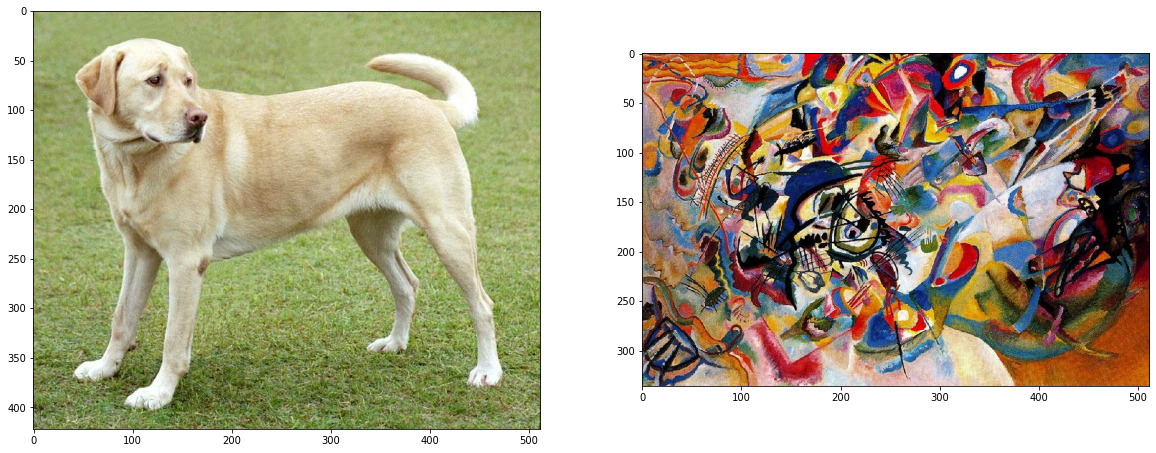

In [5]:
plt.subplot(1,2,1)
plt.imshow(tf.squeeze(content_img).numpy())

plt.subplot(1,2,2)
plt.imshow(tf.squeeze(style_img).numpy())

In [6]:
vgg = tf.keras.applications.VGG19(include_top=False)
vgg.training = False

for layer in vgg.layers:
    print(layer.name)

80142336/80134624 [==============================] - 1118s 14us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [7]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [8]:
def create_mini_model(model,style_layers,content_layers): 
    outputs = [model.get_layer(name).output for name in style_layers + content_layers]
    inputs = model.input

    model = tf.keras.models.Model([vgg.input],outputs)
    return model

In [9]:
def gram_matrix(tensor):
    gram_matrix = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    return gram_matrix/(tensor.shape[1]*tensor.shape[2])

In [10]:
class StyleContent_Extractor(tf.keras.models.Model):
    def __init__(self,model,style_layers, content_layers):
        super(StyleContent_Extractor, self).__init__()
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.model = create_mini_model(model,style_layers,content_layers)
        self.model.trainable = False

          
    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.model(preprocessed_inputs)

        style_outputs = outputs[:len(self.style_layers)]
        content_outputs = outputs[len(self.style_layers):]

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {
              content_name:output 
              for content_name,output in zip(self.content_layers,content_outputs)
        }

        style_dict = {
              style_name:output 
              for style_name,output in zip(self.style_layers,style_outputs)
        }

        return {'style':style_dict,'content':content_dict}

In [11]:
extractor = StyleContent_Extractor(vgg,style_layers, content_layers)
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

In [12]:
style_weight=1e-2
content_weight=1e4

In [13]:
def calculate_loss(outputs):
    style_outputs = outputs['style']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight/len(style_outputs)

    content_outputs = outputs['content']
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                           for name in content_outputs.keys()])
    content_loss *= content_weight/len(content_outputs)
    
    total_loss = style_loss + content_loss
    return total_loss

In [14]:
generated_img = tf.Variable(content_img)

In [15]:
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [16]:
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = calculate_loss(outputs)

    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

....................................................................................................

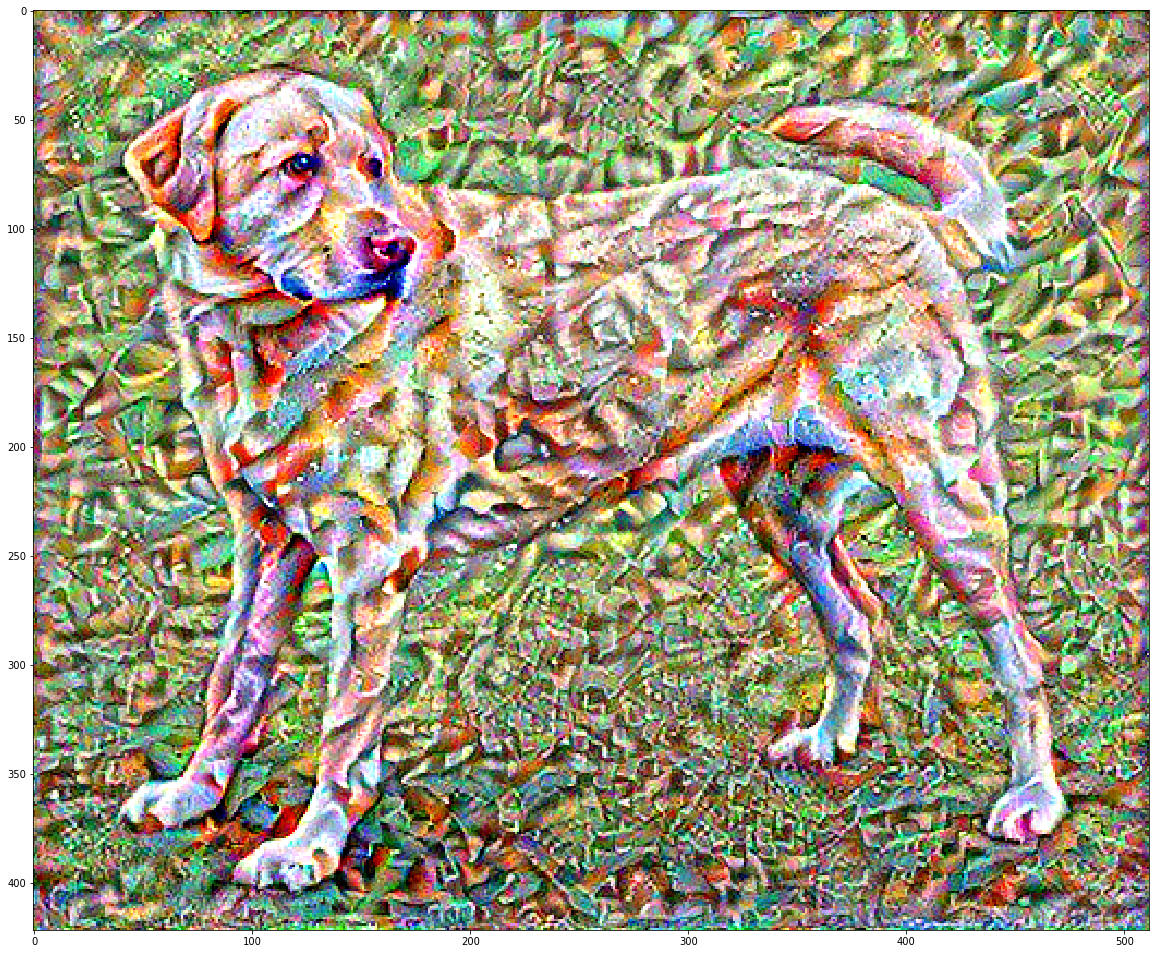

Train step: 100
.....

KeyboardInterrupt: 

In [17]:
epochs = 2
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(generated_img)
        print(".", end='')
    plt.imshow(tf.squeeze(generated_img).numpy())
    plt.show()
    print("Train step: {}".format(step))
